# Содержание

>[Содержание](#scrollTo=dbIx_Dto8mmB)

>[Домашнее задание](#scrollTo=G8X5_0854Lwb)

>>[1 Импорт необходимых библиотек](#scrollTo=s5CuoU_04aOZ)

>>>[1.1 Проверка подключения к среде выполнения](#scrollTo=35LTS8eX-xTJ)

>>>[1.2 Подключение к google disk](#scrollTo=0ZYDikYC-8xL)

>>[2 Определение классов и функций для работы](#scrollTo=lmyzpUBl4kpS)

>>[3 Загрузка и распаковка датасета](#scrollTo=sZuE5fM-4zZq)

>>[4 Определение путей к изображениям](#scrollTo=9ubjBwYP4-Lj)

>>[5 Визуализация одного из изображений и его маски](#scrollTo=hedJ42cf5ax9)

>>[6 Создание рабочего датасета](#scrollTo=FMhZf7Ew5Gyh)

>>[7 Определение модели](#scrollTo=fmFzLY7hIJJF)

>>[8 Запись рабочего датасета в собственный класс](#scrollTo=xJmhxbcuIPlt)

>>[9 Разделение рабочего датасета на тренировочный и тестовый](#scrollTo=LXMoLyyczwEY)

>>[10 Запись датасетов в Dataloader](#scrollTo=AKNTZ7R27mkK)

>>[11 Определение функции потерь, метрики и оптимизатора](#scrollTo=kv1AB8a4IkrT)

>>[12 Определение итеративных выборок данных](#scrollTo=BPZub-e1KG2B)

>>[13 Обучение модели](#scrollTo=A5EZdtljKrEG)

>>[14 Визуализация изображений и маски](#scrollTo=IhFeDPXwVWgC)



# Домашнее задание

Необходимо подготовить датасет https://www.kaggle.com/olekslu/makeup-lips-segmentation-28k-samples для обучения модели на сегментацию губ

Обучить модель на выбор из segmentation_models_pytorch


## 1 Импорт необходимых библиотек

In [1]:
!pip install segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 36.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 66.0 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=d443a42d9c82b9592334e311bf103f468b412a1fabea80e8b3a9c83b74cac8b5
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60943 sha256=34b586ee8727b525bd95fb6d01c3d87f07f755f24e1b51427066058338464a50
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f53

In [2]:
import os
import cv2
import time
import torch
import shutil
import numpy as np
import pandas as pd
from PIL import Image
from torch import nn, optim
import matplotlib.pyplot as plt
from google.colab import drive, files
import segmentation_models_pytorch as smp
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from segmentation_models_pytorch import utils as smp_utils

### 1.1 Проверка подключения к среде выполнения

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

### 1.2 Подключение к google disk

In [4]:
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## 2 Определение классов и функций для работы

In [68]:
def get_orig(image):
    image = image.permute(1, 2, 0)
    image = image.numpy()
    image = np.clip(image, 0, 1)
    return image

def makeDir(dir_name):
    if os.path.exists(dir_name):
        shutil.rmtree(dir_name)
    os.makedirs(dir_name)

def resize_an_image_and_mask(current_dir, new_dir, new_size):

    start = time.time()

    max_count = len(os.listdir(current_dir))
    count = 0

    for img in os.listdir(current_dir):
        count += 1
        image = cv2.imread(current_dir + img)
        resized_image = cv2.cvtColor(cv2.resize(image, (new_size, new_size)), cv2.COLOR_BGR2RGB)
        cv2.imwrite(new_dir + img, resized_image)
        print("", end=f"\r{img} image resized {max_count - count}")

    stop = time.time()

    print(f"\nIt's took {stop - start} sec")

    # image = cv2.imread(image_filename)
    # mask = cv2.imread(mask_filename)
    # resized_image = cv2.cvtColor(cv2.resize(image, (new_size, new_size)), cv2.COLOR_BGR2RGB)
    # resized_mask = cv2.cvtColor(cv2.resize(mask, (new_size, new_size)), cv2.COLOR_BGR2RGB)

    # cv2.imwrite(new_img_path, resized_image)
    # cv2.imwrite(new_mask_path, resized_mask)

    # return resized_image, resized_mask

class MyOwnLipsDataset(torch.utils.data.Dataset):
    def __init__(self, data, preprocessing=None):
        self.data = data
        self.preprocessing = preprocessing
        self.images_paths = self.data.iloc[:, 0]
        self.masks_paths = self.data.iloc[:, 1]
        self.data_len = len(self.data.index)

    def __len__(self):
        return self.data_len

    def __getitem__(self, idx):
        img_path = self.images_paths[idx]
        mask_path = self.masks_paths[idx]
        imgr = cv2.imread(img_path)
        maskr = cv2.imread(mask_path)
        img = imgr.astype(float)

        if self.preprocessing:
            img = self.preprocessing(img)
            img = torch.as_tensor(img)
        else:
            img = torch.as_tensor(img)
            img /= 255.0

        img = img.permute(2, 0, 1)
        cls_mask_1 = mask[..., 1]
        cls_mask_1 = np.where(mask > 50, 1, 0)[:,:,1]
        cls_mask_1 = cls_mask_1.astype('float')
        masks = [cls_mask_1]
        masks = torch.as_tensor(masks, dtype=torch.float)

        return img.float(), masks

## 3 Загрузка и распаковка датасета

In [6]:
path_dir = "/content/drive/MyDrive/Lips/"

In [ ]:
# makeDir(path_dir)

In [ ]:
# !unzip /content/drive/MyDrive/archive_lips.zip -d /content/drive/MyDrive/Lips/

## 4 Определение путей к изображениям

In [7]:
work_dir = path_dir + "set-lipstick-original/"
img_dir = work_dir + "720p/"
mask_dir = work_dir + "mask/"

In [8]:
os.listdir(work_dir)

['list.csv', '720p', 'mask']

In [26]:
df_csv = pd.read_csv(work_dir + "list.csv")

In [27]:
df_csv.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,mask
0,image00000001.jpg,1280,720,Lips,661,394,776,444,mask00000001.png
1,image00000002.jpg,1280,720,Lips,557,336,682,392,mask00000002.png
2,image00000003.jpg,1280,720,Lips,553,369,684,427,mask00000003.png
3,image00000004.jpg,1280,720,Lips,555,351,681,408,mask00000004.png
4,image00000005.jpg,1280,720,Lips,555,351,680,407,mask00000005.png


## 5 Визуализация одного из изображений и его маски

Text(0.5, 1.0, '(720, 1280, 3)')

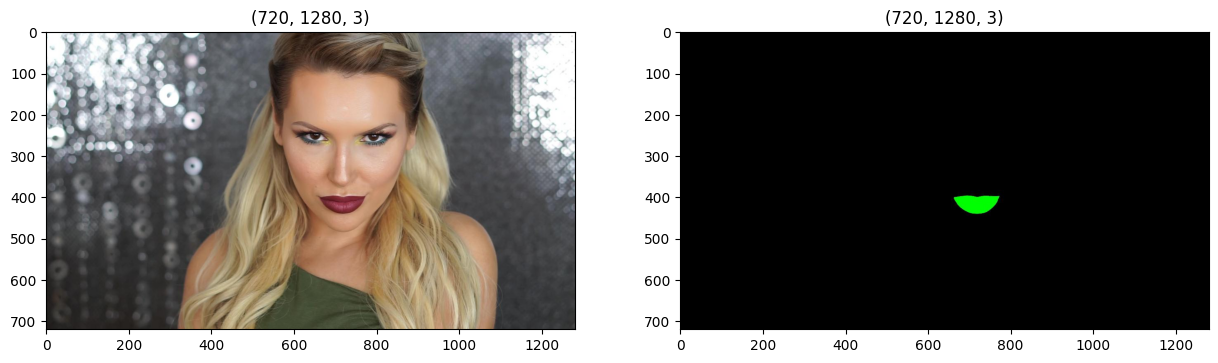

In [12]:
num_img = 0
img = plt.imread(img_dir + df_csv['filename'][num_img])
mask = plt.imread(mask_dir + df_csv['mask'][num_img])
fig, axes = plt.subplots(1, 2, figsize=(15, 8))
axes[0].imshow(img)
axes[0].set_title(img.shape)
axes[1].imshow(mask)
axes[1].set_title(img.shape)

## 6 Создание рабочего датасета

In [15]:
lips_resize_dir = "/content/drive/MyDrive/Lips_resize/"
resize_img_dir = "/content/drive/MyDrive/Lips_resize/720/"
resize_mask_dir = "/content/drive/MyDrive/Lips_resize/mask/"

In [ ]:
# makeDir(lips_resize_dir)
# makeDir(resize_img_dir)
# makeDir(resize_mask_dir)

In [ ]:
# resize_an_image_and_mask(img_dir, resize_img_dir, 152)

image00000595.jpg image resized

In [16]:
# resize_an_image_and_mask(mask_dir, resize_mask_dir, 152)

mask00000705.png image resized 0
It's took 7683.347325563431 sec


In [48]:
i = 12345
num_img_r = os.listdir(resize_img_dir)[i]

Text(0.5, 1.0, '(152, 152, 3)')

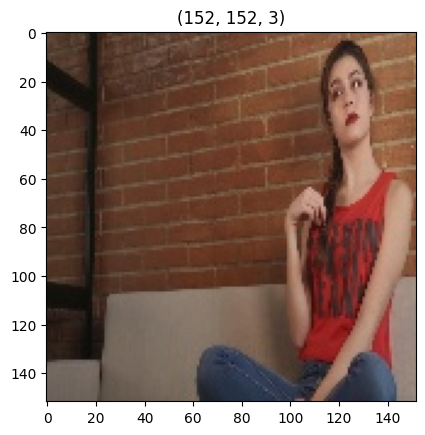

In [51]:
imgr = cv2.imread(resize_img_dir + num_img_r)
plt.imshow(imgr)
plt.title(imgr.shape)

In [19]:
len(os.listdir(resize_img_dir)), len(os.listdir(resize_mask_dir))

(28594, 28540)

In [30]:
img_dir_list = os.listdir(resize_img_dir)
img_dir_list.sort()
mask_dir_list = os.listdir(resize_mask_dir)
mask_dir_list.sort()

In [31]:
df_csv_mask_list = list(df_csv['mask'])
df_csv_mask_list.sort()

In [32]:
out_value = []
count = 0
for i in df_csv_mask_list:
    if i not in mask_dir_list:
        count += 1
        out_value.append(i)

In [33]:
df_csv.count()

filename    28594
width       28594
height      28594
class       28594
xmin        28594
ymin        28594
xmax        28594
ymax        28594
mask        28594
dtype: int64

In [34]:
df_csv_new = df_csv[df_csv['mask'].isin(out_value) == False]

In [35]:
df_csv_new.count()

filename    28540
width       28540
height      28540
class       28540
xmin        28540
ymin        28540
xmax        28540
ymax        28540
mask        28540
dtype: int64

In [36]:
df = pd.DataFrame({"main_img": resize_img_dir + df_csv_new['filename'], "mask_img": resize_mask_dir + df_csv_new['mask']})
df.head()

,main_img,mask_img
0,/content/drive/MyDrive/Lips_resize/720/image00...,/content/drive/MyDrive/Lips_resize/mask/mask00...
1,/content/drive/MyDrive/Lips_resize/720/image00...,/content/drive/MyDrive/Lips_resize/mask/mask00...
2,/content/drive/MyDrive/Lips_resize/720/image00...,/content/drive/MyDrive/Lips_resize/mask/mask00...
3,/content/drive/MyDrive/Lips_resize/720/image00...,/content/drive/MyDrive/Lips_resize/mask/mask00...
4,/content/drive/MyDrive/Lips_resize/720/image00...,/content/drive/MyDrive/Lips_resize/mask/mask00...


In [56]:
df = df[:int(df.count()[0] / 2)]

In [57]:
df.count()

main_img    14270
mask_img    14270
dtype: int64

In [58]:
df['main_img'][num_img], df['mask_img'][num_img]

('/content/drive/MyDrive/Lips_resize/720/image00000001.jpg',
 '/content/drive/MyDrive/Lips_resize/mask/mask00000001.png')

In [59]:
df.reset_index(drop=True, inplace=True)

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14270 entries, 0 to 14269
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   main_img  14270 non-null  object
 1   mask_img  14270 non-null  object
dtypes: object(2)
memory usage: 223.1+ KB


## 7 Определение модели

In [61]:
BACKBONE = 'resnet34'
segmodel = smp.PSPNet(BACKBONE, in_channels=3, classes=1, activation='sigmoid').to(device)
preprocess_input = smp.encoders.get_preprocessing_fn(BACKBONE, pretrained='imagenet')

## 8 Запись рабочего датасета в собственный класс

In [62]:
dataset = MyOwnLipsDataset(df, preprocessing=preprocess_input)

## 9 Разделение рабочего датасета на тренировочный и тестовый

In [63]:
# 70 % в тренировочную выборку, 30 - в тестовую
X_train, X_test = train_test_split(df, test_size=0.3)

# Упорядочиваем индексацию
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

# Оборачиваем каждую выборку в наш кастомный датасет
train_data = MyOwnLipsDataset(X_train, preprocessing=preprocess_input)
test_data = MyOwnLipsDataset(X_test, preprocessing=preprocess_input)

## 10 Запись датасетов в Dataloader

In [64]:
train_data_loader = DataLoader(
    train_data,
    batch_size=8,
    shuffle=True
)
test_data_loader = DataLoader(
    test_data,
    batch_size=4,
    shuffle=False
)

## 11 Определение функции потерь, метрики и оптимизатора

In [65]:
criterion = smp_utils.losses.BCELoss()
metrics = [smp_utils.metrics.IoU(),]

optimizer = torch.optim.Adam(params=segmodel.parameters(), lr=0.001)

## 12 Определение итеративных выборок данных

In [66]:
train_epoch = smp.utils.train.TrainEpoch(
    segmodel,
    loss=criterion,
    metrics=metrics,
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    segmodel,
    loss=criterion,
    metrics=metrics,
    device=device,
    verbose=True,
)

## 13 Обучение модели

In [67]:
max_score = 0
num_epoch = 2
for i in range(0, num_epoch):
    print(f'Epoch: {i + 1}')
    train_logs = train_epoch.run(train_data_loader)
    valid_logs = valid_epoch.run(test_data_loader)

    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(segmodel, './best_model.pth')
        print('Model saved!')

Epoch: 1
valid: 100%|██████████| 1071/1071 [10:28<00:00,  1.70it/s, bce_loss - 0.00396, iou_score - 0.687]
Model saved!
Epoch: 2
valid: 100%|██████████| 1071/1071 [04:19<00:00,  4.13it/s, bce_loss - 0.003938, iou_score - 0.6639]


## 14 Визуализация изображений и маски

In [70]:
data_iter = iter(train_data_loader)
images, labels = next(data_iter)
images, labels = images.to(device), labels.to(device)

outputs = segmodel(images)

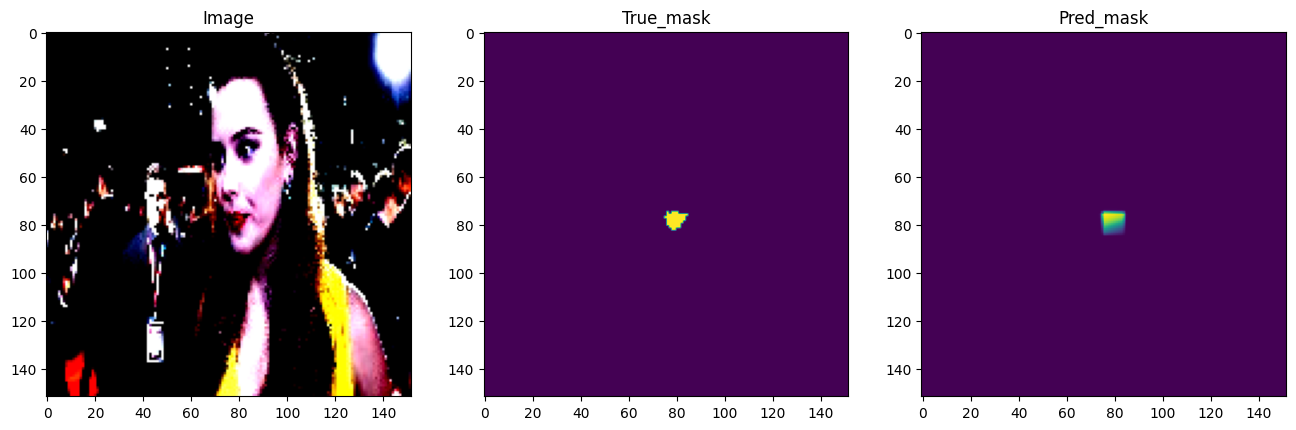

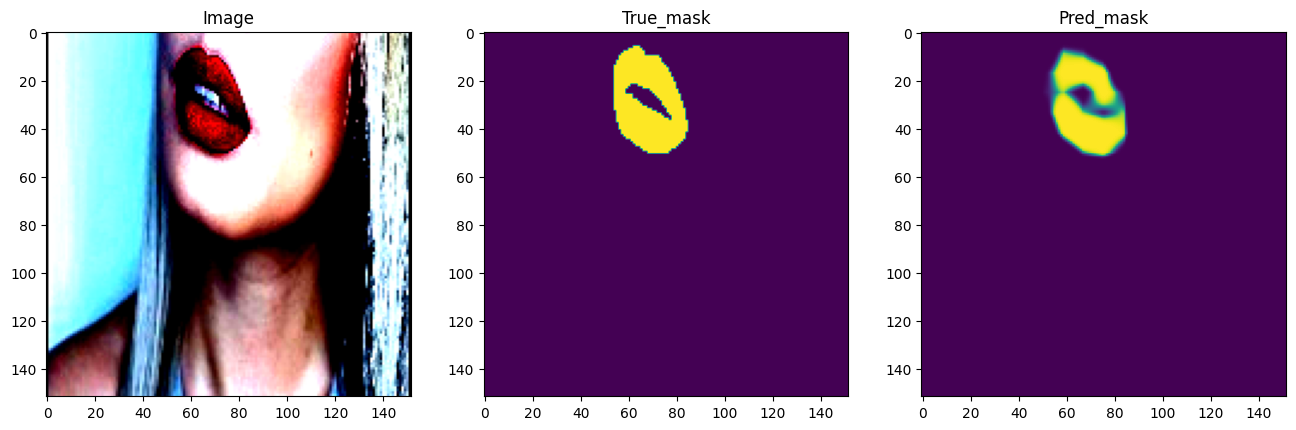

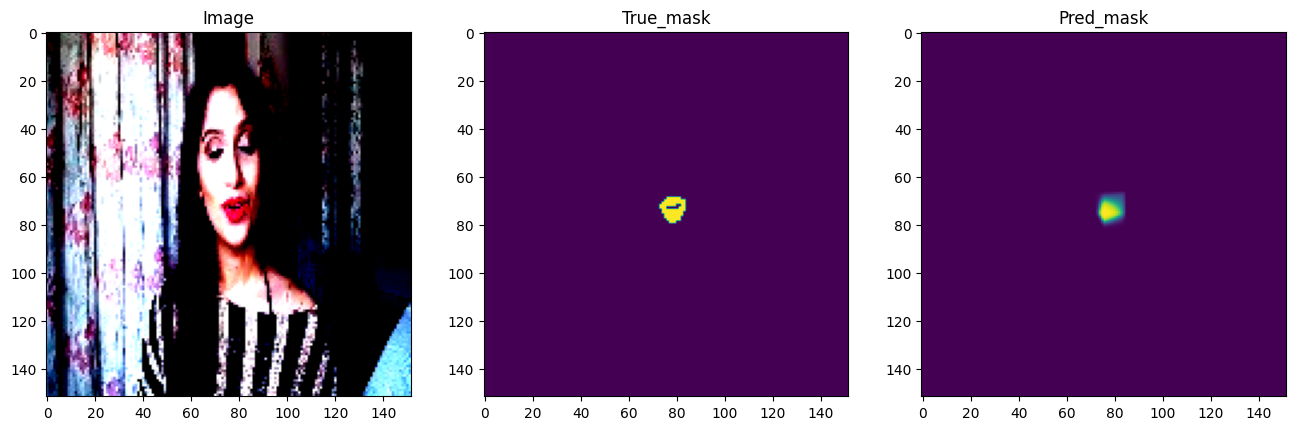

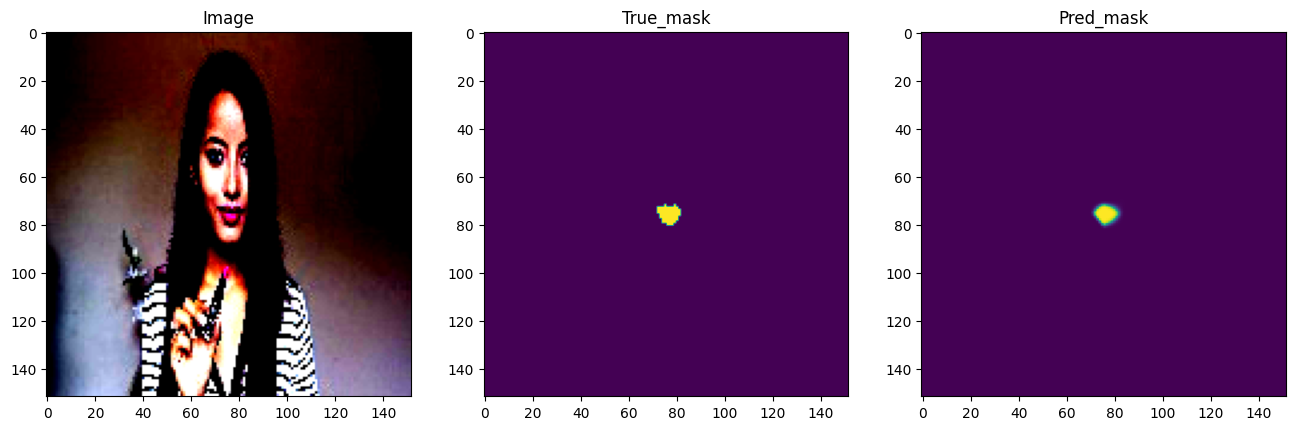

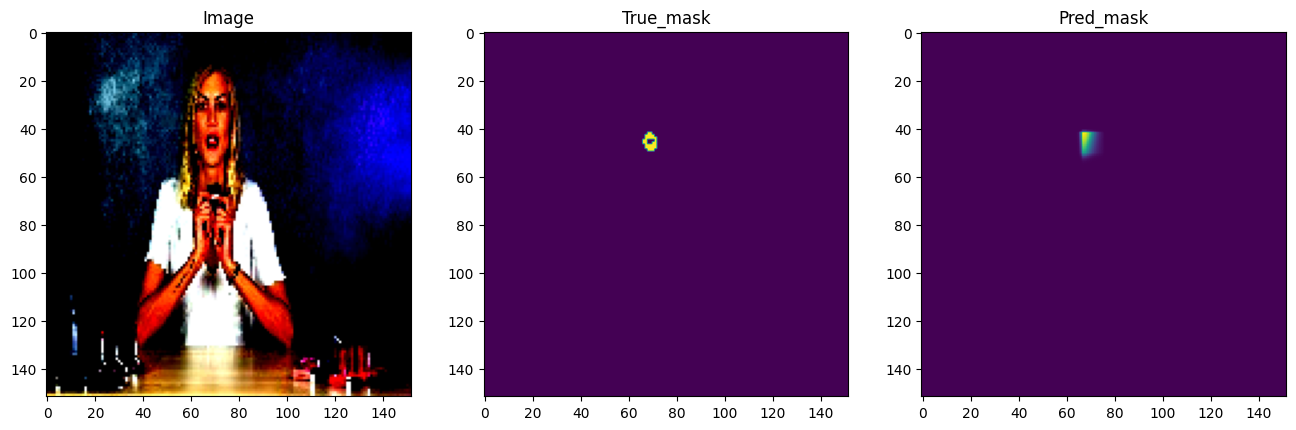

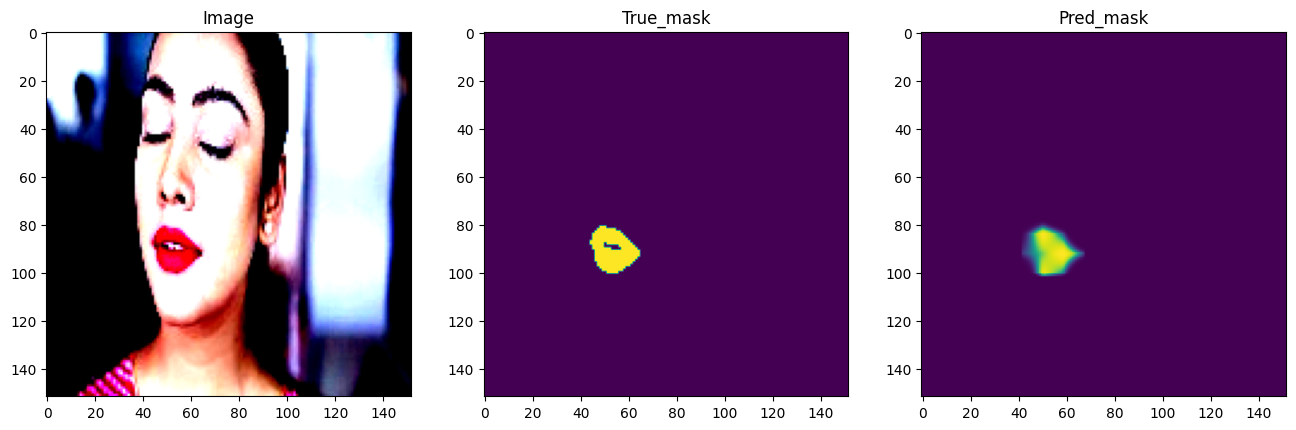

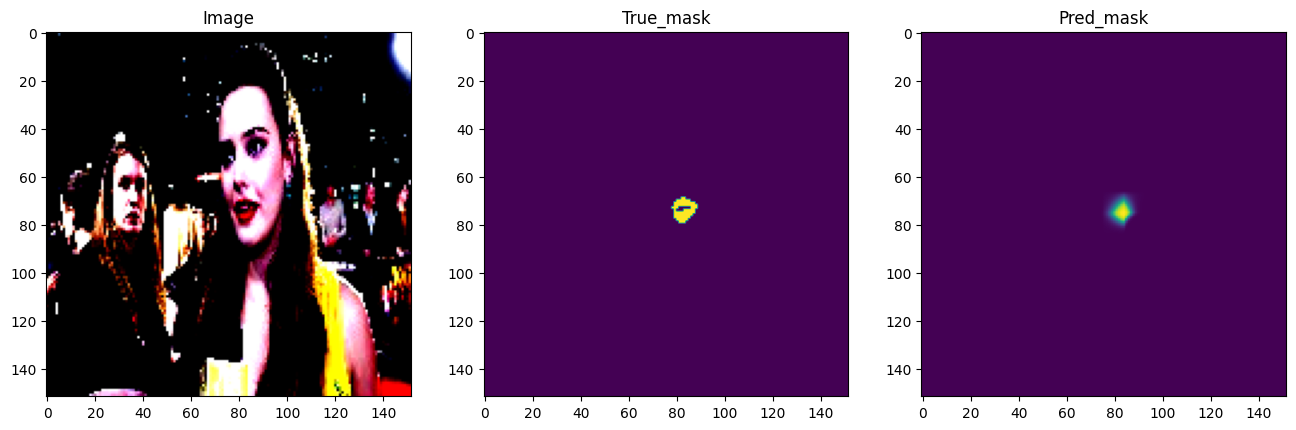

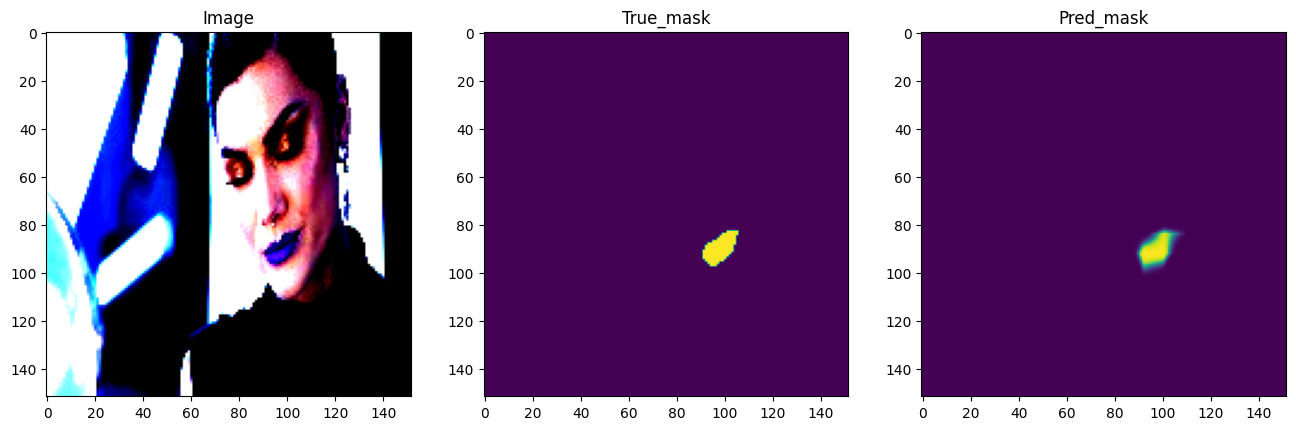

In [71]:
for i in range(images.shape[0]):

    fig , (ax_1, ax_2, ax_3) = plt.subplots(1, 3, figsize=(16,5))

    image = images[i].permute(1, 2, 0)

    ax_1.imshow(image.cpu())
    ax_1.set_title('Image')

    ax_2.imshow(labels[i, ].cpu().permute(1, 2, 0))
    ax_2.set_title('True_mask')

    ax_3.imshow(outputs.detach().cpu()[i, ].permute(1, 2, 0))
    ax_3.set_title('Pred_mask')
